<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch5_RungeKutta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Runge-Kutta formula

In [3]:
import numpy as np
from numpy import sin, cos, exp
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate # use for scipy.interpolate.CubicHermiteSpline
from scipy.integrate import solve_ivp
mpl.rcParams["figure.figsize"] = [8,6] # or 7, 4 or 10,8
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['mathtext.fontset'] = 'cm'

### Let's solve an IVP
$$y' = -k (y-\cos(t))$$
for $k=5$ and $0 \le t \le 20$ with $y(0)=0.2$.

There's a known true solution
$$y(t)=\frac{y_0 - k^2}{k^2+1}e^{-kt} + k\frac{\sin(t) + k\cos(t)}{k^2+1}$$

t shape: (65,)
y shape: (1, 65)


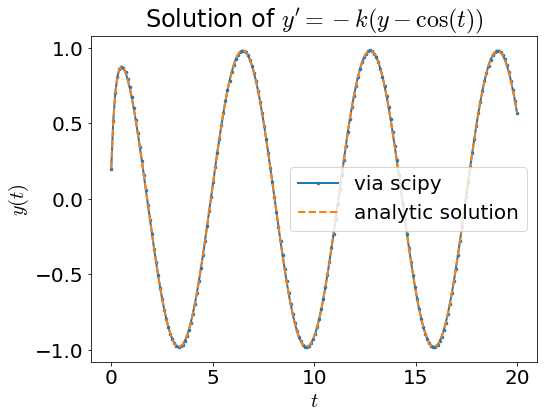

In [4]:
k  = 5 # a parameter
f  = lambda t,y: -k*( y - cos(t) )
y0 = .2;

# We have a known true solution
#   see https://github.com/cu-numcomp/numcomp-class/blob/master/DifferentialEquations.ipynb
y_true = lambda t : (y0 - k**2/(k**2+1) )*exp(-k*t) + k*(sin(t) + k*cos(t))/(k**2+1)


tspan = [0.0,20.0];

sol = solve_ivp(f,tspan,[y0],dense_output=True)
print("t shape:",sol.t.shape)
print("y shape:",sol.y.shape)

y_interpolated = sol.sol # a function!
t_points  = np.linspace(tspan[0],tspan[1],200)

plt.plot(t_points, y_interpolated(t_points)[0],".-",MarkerSize=5,label='via scipy')
plt.plot(t_points, y_true(t_points),"--",MarkerSize=5,label='analytic solution')
plt.xlabel("$t$"); plt.ylabel("$y(t)$");
plt.title("Solution of $y'=-k(y-\cos(t))$");
plt.legend();

### We have several variants of Euler's method
e.g., 2-state Runge Kutta formula

These go by all kinds of names. We'll refer to them as follows:

- Modified Euler's method

|  |     |     |
|---|-----|-----|
| 0 |     |     |
| 1 | 1   |     |
|   | 1/2 | 1/2 |

- Improved Euler's method

|  |     |     |
|---|-----|-----|
| 0 |     |     |
| 1/2 | 1/2   |     |
|   | 0 | 1 |


- Heun's 2-stage method

|  |     |     |
|---|-----|-----|
| 0 |     |     |
| 2/3 | 2/3   |     |
|   | 1/4 | 3/4 |

In [107]:
def generic_IVP_solver( f, tspan, y0, h=0.1, dense_output=False,method="Euler"):
  """ Solve IVP y' = f(t,y) on a <= t <= b, y(a)=y0, via variant of Euler with stepsize h
  This code has NOT been tested to work with systems.
  Returns tHist, wHist where wHist[i] approximates y( tHist[i] )
  """
  if len(tspan) is not 2:
    raise ValueError("tspan must be array of length 2")
  a, b = tspan[0], tspan[1]  
  # Initialize
  t    = a
  w    = y0
  # Update history
  tHist = [t]
  wHist = [w]  # w[i] approximates y( t[i] )
  dydtHist = []
  # Loop
  if method.lower() == "euler":
    while t < b :
      tNext = min(t+h,b)  # don't go too far
      hh    = tNext - t   # hh is just h except perhaps at the last time step
      dydt  = f(t,w)
      w    += hh*dydt     # this is the heart of forward Euler
      #print(t,w,dydt) # debugging
      t     = tNext
      # Update history
      tHist.append(t)
      wHist.append(w)
      dydtHist.append(dydt)
  elif method.lower() == "improved euler":
    # see https://github.com/stephenbeckr/numerical-analysis-class/blob/master/Notes/Ch5_RungeKutta_intro.pdf
    while t < b :
      tNext = min(t+h,b)  # don't go too far
      hh    = tNext - t
      dydt  = f(t,w)
      wHalf = w + hh/2*dydt
      w     += hh*f(t+hh/2,wHalf)
      t     = tNext
      # Update history
      tHist.append(t)
      wHist.append(w)
      dydtHist.append(dydt)
  elif method.lower() == "modified euler":
    while t < b :
      tNext = min(t+h,b)  # don't go too far
      hh    = tNext - t
      dydt  = f(t,w)
      wEuler= w + hh*dydt
      w     += hh/2*( dydt + f(tNext,wEuler) )
      t     = tNext
      # Update history
      tHist.append(t)
      wHist.append(w)
      dydtHist.append(dydt)
  elif method.lower() == "heun":  # Heun's 2 stage, 2nd order method
    while t < b :
      tNext = min(t+h,b)  # don't go too far
      hh    = tNext - t
      dydt  = f(t,w)
      w     += hh/4*( dydt + 3*f(t+2/3*hh,w+hh*2/3*dydt) )
      t     = tNext
      # Update history
      tHist.append(t)
      wHist.append(w)
      dydtHist.append(dydt)
  else:
    raise ValueError('method must be "Euler", "Improved Euler", "Modified Euler" or "Heun"')

  dydtHist.append( f(t,w) )# lagged

  if dense_output is True:
    sol = scipy.interpolate.CubicHermiteSpline(tHist,wHist,dydtHist)
    return np.array(tHist), np.array(wHist), sol
  else:  
    return np.array(tHist), np.array(wHist)

Run all of these methods and record error

In [13]:
hList = np.logspace(-1,-4,10)
t  = np.linspace(tspan[0],tspan[1],1000)
ListOfMethods = ['Euler','Improved Euler','Modified Euler','Heun']
Results = {}
for method in ListOfMethods:
  errorList = []
  for h in hList:
    tHist, wHist, y_interpolated = generic_IVP_solver( f, tspan, y0, h=h,dense_output=True,method=method)
    err = np.linalg.norm( y_true(t) - y_interpolated(t), ord=np.inf)
    errorList.append( err )
  Results[method] = errorList

Plot the error. Does it decay as it should?

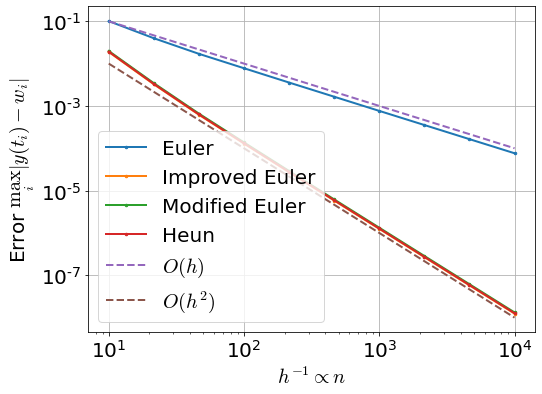

In [21]:
for method in ListOfMethods:
  plt.loglog(1/hList, Results[method],".-",MarkerSize=5,label=method);

plt.loglog(1/hList, hList,'--',label='$O(h)$');
plt.loglog(1/hList, hList**2,'--',label='$O(h^2)$');
plt.legend();
plt.grid()
plt.ylabel('Error $\max_i |y(t_i) - w_i|$')
plt.xlabel('$h^{-1} \propto n$');

### Another way
We'll make a generic method that takes in **any** RK Butcher array (this is not an *efficient* way to do it, but it lets us quickly try new RK formula)

Recall:

- Euler's method

|  |     |
|---|-----|
| 0 |     |
|   | 1 |


- Modified Euler's method

|  |     |     |
|---|-----|-----|
| 0 |     |     |
| 1 | 1   |     |
|   | 1/2 | 1/2 |

- Improved Euler's method

|  |     |     |
|---|-----|-----|
| 0 |     |     |
| 1/2 | 1/2   |     |
|   | 0 | 1 |


- Heun's 2-stage method

|  |     |     |
|---|-----|-----|
| 0 |     |     |
| 2/3 | 2/3   |     |
|   | 1/4 | 3/4 |

- Heun's 3-stage method

|  |     |     |  |
|---|-----|-----|--|
| 0 |     |     | |
 1/3 | 1/3 | | |
| 2/3 |0 |2/3   | |
|   | 1/4 |0| 3/4 |

- "Standard" 4th order RK, or "RK4"

|  |     |     |  | |
|---|-----|-----|--|--|
| 0 |     |     | | |
 1/2 | 1/2  | | | |
| 1/2 |0 |1/2   | | |
| 1 |0 |0   | 1| |
|   | 1/6 |1/3| 1/3 |1/6|

In [138]:
def make_Butcher_array( method="Euler" ):
  if method.lower() == 'euler':
    c = []
    A = []
    b = 1
  elif method.lower() == 'modified euler':
    c = [1]
    A = [1]
    b = [1/2, 1/2]
  elif method.lower() == "improved euler":
    c = [1/2]
    A = [1/2]
    b = [0,1]
  elif method.lower() == "heun":
    c = [2/3]
    A = [2/3]
    b = [1/4, 3/4]
  elif method.lower() == 'heun3':
    c = [1/3,2/3]
    A = [ [1/3], [0, 2/3]]
    b = [1/4, 0, 3/4]
  elif method.lower() == 'rk4':
    c = [1/2,1/2,1]
    A = [ [1/2], [0, 1/2],[0,0,1]]
    b = [1/6,1/3,1/3,1/6]
  else:
    raise ValueError('unknown method type')
  return c, A, b

In [139]:
def generic_RK_solver( f, tspan, y0, h=0.1, dense_output=False,ButcherArray=make_Butcher_array() ):
  """ Solve IVP y' = f(t,y) on a <= t <= b, y(a)=y0, via generic RK with stepsize h
  This code has NOT been tested to work with systems.
  Returns tHist, wHist where wHist[i] approximates y( tHist[i] )
  Note: for a real solver, you would hardcode in the RK formula
    This implementation is not that efficient
  """
  if len(tspan) is not 2:
    raise ValueError("tspan must be array of length 2")
  a, b = tspan[0], tspan[1]  
  # Initialize
  t    = a
  w    = y0
  # Update history
  tHist = [t]
  wHist = [w]  # w[i] approximates y( t[i] )
  dydtHist = []
  # Get ButcherArray
  c, A, weights = ButcherArray
  c = np.asarray(c)
  A = np.asarray(A)
  weights = np.atleast_1d(np.asarray(weights)) # already use "b" for time span
  s = weights.size
  k = np.zeros(s)
  # Loop
  while t < b :
    tNext = min(t+h,b)  
    hh    = tNext - t   
    dydt  = f(t,w)

    # Start RK
    k[0]  = hh*dydt
    for j in range(1,s):
      k[j] = hh*f(t+hh*c[j-1], w + np.dot(A[j-1],k[:j])  )
    
    w    += np.dot(k,weights)
    #print(t, w, dydt, k,weights)
    t     = tNext
    # Update history
    tHist.append(t)
    wHist.append(w)
    dydtHist.append(dydt)

  dydtHist.append( f(t,w) )# lagged

  if dense_output is True:
    sol = scipy.interpolate.CubicHermiteSpline(tHist,wHist,dydtHist)
    return np.array(tHist), np.array(wHist), sol
  else:  
    return np.array(tHist), np.array(wHist)

Loop over methods and different stepsizes, recording the error

In [134]:
hList = np.logspace(-1,-3,10)
t  = np.linspace(tspan[0],tspan[1],1000)
ListOfMethods = ['Euler','Improved Euler','Modified Euler','Heun','Heun3','RK4']
Results = {}
for method in ListOfMethods:
  errorList = []
  for h in hList:
    tHist, wHist, y_interpolated = generic_RK_solver( f, tspan, y0, h=h, dense_output=True,ButcherArray=make_Butcher_array(method) )
    err = np.linalg.norm( y_true(t) - y_interpolated(t), ord=np.inf)
    errorList.append( err )
  Results[method] = errorList

Plot the error. Is it as we expected?

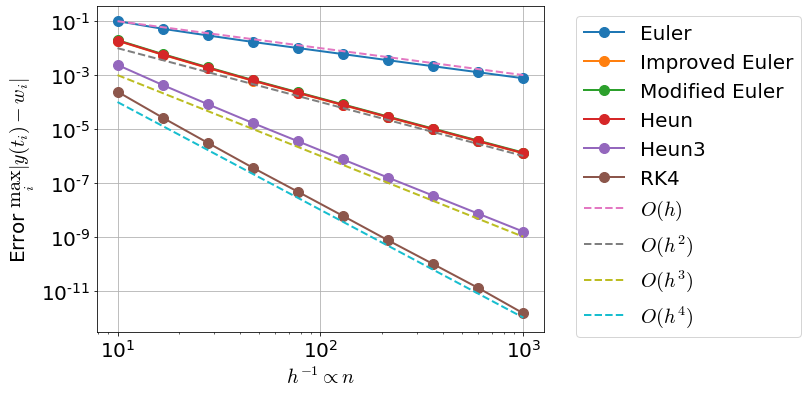

In [137]:
for method in ListOfMethods:
  plt.loglog(1/hList, Results[method],"o-",MarkerSize=10,label=method);

plt.loglog(1/hList, hList,'--',label='$O(h)$');
plt.loglog(1/hList, hList**2,'--',label='$O(h^2)$');
plt.loglog(1/hList, hList**3,'--',label='$O(h^3)$');
plt.loglog(1/hList, hList**4,'--',label='$O(h^4)$');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.grid()
plt.ylabel('Error $\max_i |y(t_i) - w_i|$')
plt.xlabel('$h^{-1} \propto n$');

## Are higher-order methods worth it?
They are a bit slower to run. Is this slow-down worth it?

For a given accuracy, lower-order methods need a smaller $h$, and that causes them to be slower. So is it a tie?

No! Or at least, not for most accuracies.  Usually the higher-order methods are definitely worth it